**OBJECTIVE:** Run modSAR algorithm on OSM-S4 qsar dataset

In [61]:
import math
import scipy
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
import modSAR
from modSAR.network_algorithms import ModSAR
from modSAR.dataset import QSARDataset, QSARDatasetIO

# plotnine is the python version of ggplot2
from plotnine import *

import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import rdkit.Geometry
from rdkit.Chem import rdFMCS, PandasTools
from rdkit.Chem.Draw import IPythonConsole 

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

%matplotlib inline

# Context

**Author: Jonathan Cardoso-Silva (Github: @jonjoncardoso | Twitter: @jonjon_cardoso)**

In 2019, I participated in the [OSM-S4 predictive model competition](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1) with a variation of [modSAR](https://doi.org/10.1007/s10822-019-00228-6), an algorithm I developed during my PhD at King's College London. Back then, I used [CDK 2.x](https://cdk.github.io/) library to compute ~200 molecular descriptors for every molecule in the dataset and produced a prediction model that did not perform too well - only 12 of 33 predictions in the hidden external data set were considered "correct". 

**_In this notebook, I revisit this modelling problem with the same algorithm but this time I am using molecular fingerprints (namely Morgan Fingerprints from RDKit) not just as a means to compute molecular similarity but also as features to the regression model._**

# Load Data

The dataset I am using here is made of Open Source Malaria Series4 (OSM-S4) molecules compiled by [@edwintse](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1) and preprocessed by [@wvanhoorn](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1#issuecomment-522630124).

This time, I am using Morgan fingerprints in two variantes, radius=2 and radius=4, as features to the regression model of modSAR which were generated in the `OSM-S4 - Notebook 01 - Preprocessing.ipynb`.

**Radius=2**

In [3]:
dataset_morgan2 = \
    QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='../data/osm_qsar_dataset_morgan2.xlsx',
                   calculate_similarity=False)
    

    
dataset_morgan2

QSARDataset OSM4 
 -- Samples : 347
 -- Features:  1024

Most importantly, these objects have a `X` and `y` dataframes representing the fingerprints and activity, respectively.

In [17]:
dataset_morgan2.X.iloc[0:2,:]

Bit_0000  Bit_0001  Bit_0002  ...  Bit_1021  Bit_1022  Bit_1023
OSM_ID                                 ...                              
OSM-A-1         0         0         0  ...         0         0         0
OSM-A-2         0         0         0  ...         0         0         0

[2 rows x 1024 columns]

In [16]:
dataset_morgan2.y

pIC50
OSM_ID             
OSM-A-1    5.437163
OSM-A-2    5.989437
OSM-A-3    6.931323
OSM-E-1    4.301030
OSM-E-2    4.301030
...             ...
OSM-S-631  4.602060
OSM-S-632  4.602060
OSM-S-633  4.602060
OSM-W-4    4.000000
OSM-S-194  5.985900

[347 rows x 1 columns]

**Radius = 4**

In [3]:
dataset_morgan4 = \
    QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='../data/osm_qsar_dataset_morgan4.xlsx',
                   calculate_similarity=False)
    
dataset_morgan4

QSARDataset OSM4 
 -- Samples : 347
 -- Features:  1024

# Distribution of binary fingerprints

In [80]:
plot_df = pd.melt(dataset_morgan2.X.reset_index(), id_vars='OSM_ID')
plot_df = plot_df.groupby(['OSM_ID', 'variable']).sum().reset_index()
plot_df['OSM_ID'] = plot_df['OSM_ID'].apply(lambda x: x[0:9])
plot_df.groupby(['variable']).sum().reset_index().sort_values('value', ascending=False)

variable  value
849  Bit_0849    347
356  Bit_0356    347
726  Bit_0726    339
935  Bit_0935    310
378  Bit_0378    304
..        ...    ...
720  Bit_0720      0
153  Bit_0153      0
154  Bit_0154      0
709  Bit_0709      0
0    Bit_0000      0

[1024 rows x 2 columns]

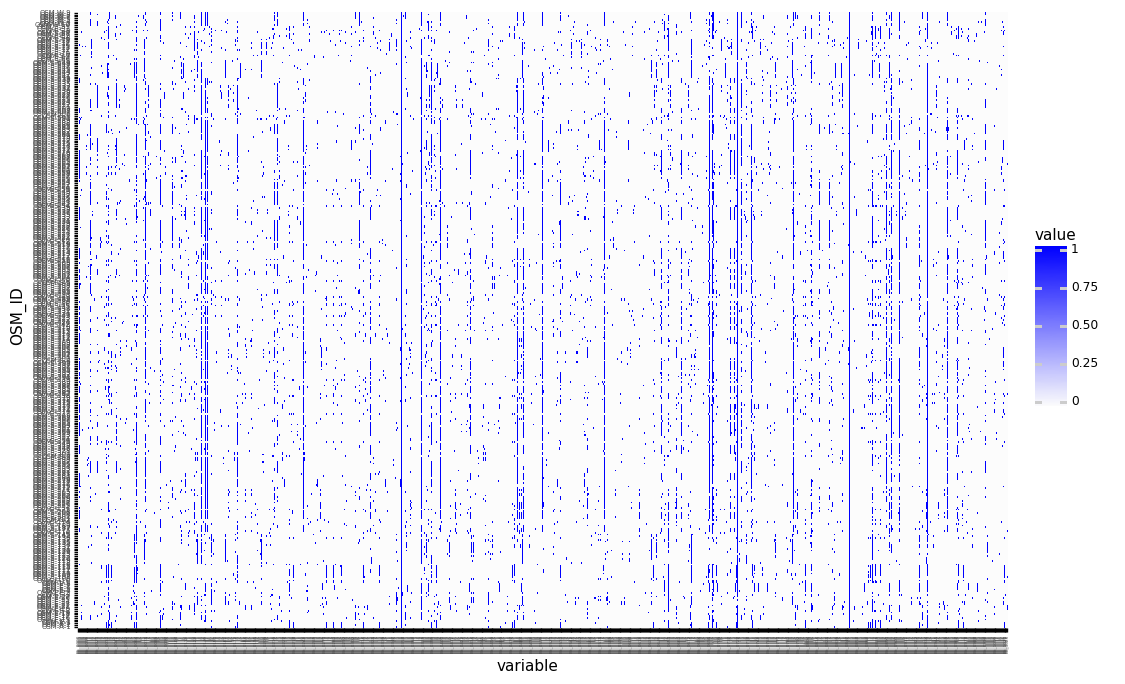

<ggplot: (8785108296242)>

In [86]:
g = (ggplot(plot_df, 
            aes(x='variable', y='OSM_ID', fill='value')) + 
     geom_tile() + 
     scale_x_discrete() + 
     scale_y_discrete() + 
     theme(figure_size=(12, 8), 
           axis_text_x=element_text(size=3, angle=90),
           axis_text_y=element_text(size=5)) + 
     scale_fill_gradient(low='#fcfcfc', high='blue'))
g

**Are there any missing values?** No :)

In [4]:
sum(dataset_morgan4.X.isnull().sum(axis=1) > 0)

0

**Visualize a sample of the dataset**

Canonical_Smiles  ...                                               Bits
OSM_ID                                                        ...                                                   
OSM-S-175  FC(F)Oc1ccc(cc1)c2nnc3cncc(C(=O)Nc4ccnc(c4)C(F...  ...  0100000100000000000100000010000000000000000000...
OSM-S-177  FC(F)Oc1ccc(cc1)c2nnc3cncc(C(=O)N4Cc5ccccc5C4)n23  ...  0100000000000000000100000010000000000000000000...
OSM-S-187            N#Cc1ccc(cc1)c2nnc3cncc(OCCc4ccccc4)n23  ...  0100000000000100000011000000000010100000001001...

[3 rows x 4 columns]
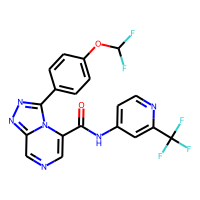
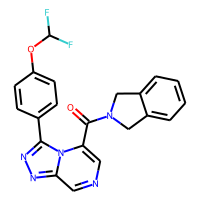
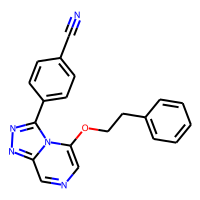

In [8]:
from rdkit.Chem import PandasTools

sample = dataset_morgan4.metadata.query("Series == '4'").iloc[0:3,:][["Canonical_Smiles", "Series"]].copy()
PandasTools.AddMoleculeColumnToFrame(sample,'Canonical_Smiles','Molecule',includeFingerprints=True)
sample = pd.merge(sample, dataset_morgan4.X, 
                  how="left", left_index=True, right_index=True)

bit_cols = [col for col in sample.columns if 'Bit' in col]
sample["Bits"] = sample.apply(lambda x: ''.join([str(x[col]) for col in bit_cols]), axis=1)
sample.drop(columns=bit_cols, inplace=True)
sample

In [9]:
selected_ids = ["OSM-S-5", "OSM-S-6", "OSM-S-106", "OSM-S-396", "OSM-S-175"]

for mol_id in selected_ids:
    mol = Chem.MolFromSmiles(dataset_morgan4.metadata.Canonical_Smiles.loc[mol_id])
    Draw.MolToFile(mol, "../data/{}.png".format(mol_id), size=(250,150), useSVG=False)

\#TODO A note to future self: To avoid creating a csv/xls file with too many columns, consider saving a single column with a string representing the on-off bits as above 

# Train ModSAR algorithm

ModSAR algorithm models regression algorithms in two stages:

1. Training data is represented as a **network** and divided into clusters by optimising the [modularity metric](https://python-louvain.readthedocs.io/en/latest/).
2. Each of this clusters (also called modules) are then modelled by the [OplraReg](https://onlinelibrary.wiley.com/doi/10.1002/minf.201800028) algorithm, a [segmented (or piecewise) regression model](https://www.theanalysisfactor.com/segmented-regression-for-non-constant-relationships/) with a regularisation penalty to select most relevant features and reduce overfitting.


ModSAR inherits a couple of parameters from OplraReg but in practice, we only need to tune $\lambda$ to define how big the effect of regularisation will be in the final piecewise linear equations. A higher $\lambda$ will lead to fewer features in the piecewise linear models and it will run quecker but if $\lambda$ is set too high, the model will have a huge bias and usually "underfit" the data. [Bias-variance tradeoff](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229).

## Cross-Validation

In this section, we will perform a cross-validation while searching for an optimum $\lambda$ parameter of modSAR.


Based on previous knowledge, we know this parameter to be optimally placed around $\lambda \approx 0.005$ - no fewer than that - so I will be sampling this parameter from a random HalfNormal distribution, i.e. $\lambda \sim \text{HalfNormal}(\mu=0.005, \sigma=0.05)$.

Randomized Search and Cross-Validation is performed with scikit-learn's [RandomizedSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search):

In [15]:
from sklearn.model_selection import GridSearchCV

modsar_alg = ModSAR(lam=0.02, metadata=dataset_morgan4.metadata)

scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]
param_distributions = {"lam": scipy.stats.halfnorm(0.005, 0.05)}

param_grid = {"lam": [i/100 for i in range(1, 11)]}


model_morgan2 = GridSearchCV(modsar_alg, 
                             return_train_score=True,
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit="neg_mean_squared_error",
                             cv=5,
                             n_jobs=5,
                             verbose=3)

model_morgan4 = GridSearchCV(modsar_alg, 
                             return_train_score=True,
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit="neg_mean_squared_error",
                             cv=5,
                             n_jobs=5,
                             verbose=3)

### Dataset: Morgan (radius=2)

Gridsearch on this dataset will take ~ 11 minutes

In [16]:
model_morgan2.fit(dataset_morgan2.X, dataset_morgan2.y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 11.0min finished


Calculating fingerprints
Calculating similarity
Best Threshold = 0.20 | ACC = 0.848
Threshold: 0.2 | k: 0
Communities: Counter({'m05': 121, 'm06': 117, 'm01': 52, 'm03': 47, 'm07': 8, 'm02': 1, 'm04': 1})
Num. samples in comm m01: 52
OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 1
SELECTED FEATURES:
['Bit_0031', 'Bit_0036', 'Bit_0080', 'Bit_0140', 'Bit_0290', 'Bit_0332', 'Bit_0350', 'Bit_0389', 'Bit_0452', 'Bit_0480', 'Bit_0703', 'Bit_0745', 'Bit_0961', 'Bit_1017']

None

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0031 (loop 1/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0036 (loop 2/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0080 (loop 3/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0140 (loop 4/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0290 (loop 5/14)

GridSearchCV(cv=5,
             estimator=ModSAR(lam=0.02, metadata=           Unnamed: 0 Series  ... duplicated  mark_to_remove
OSM_ID                        ...                           
OSM-A-1             0      1  ...       True           False
OSM-A-2             2      1  ...       True           False
OSM-A-3             4      1  ...       True           False
OSM-E-1             6      1  ...      False           False
OSM-E-2             7      1  ...      False           False
...               ...    ...  ...        ...             ...
OSM-S-631         434   not4  ...      False           False
OSM-S-632         435   not4  ...      False           False
OSM-S-633         436   not4  ...      False           False
OSM-W-4           437   not4  ...       True           False
OSM-S-194         439     TB  ...      False           False

[347 rows x 25 columns]),
             n_jobs=5,
             param_grid={'lam': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
        

In [17]:
results_df = pd.DataFrame(model_morgan2.cv_results_)
results_df["param_lam"] = results_df["param_lam"].astype(float)

selected_cols = [col for col in results_df.columns if 'split' not in col and 'std' not in col]
#results_df.loc[:, selected_cols].sort_values("param_lam")

In [37]:
# Save model to disk

from sklearn.externals import joblib
joblib.dump(model_morgan2, "../data/model_modsar_morgan2.joblib")
results_df.to_csv("../data/model_modsar_morgan2_results.csv")

In [10]:
from sklearn.externals import joblib
model_morgan2 = joblib.load("/mnt/data/results/OSM_model_round2/model_modsar_morgan2.joblib")

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
model_morgan2.best_estimator_

ModSAR(lam=0.06, metadata=           Unnamed: 0 Series  ... duplicated  mark_to_remove
OSM_ID                        ...                           
OSM-A-1             0      1  ...       True           False
OSM-A-2             2      1  ...       True           False
OSM-A-3             4      1  ...       True           False
OSM-E-1             6      1  ...      False           False
OSM-E-2             7      1  ...      False           False
...               ...    ...  ...        ...             ...
OSM-S-631         434   not4  ...      False           False
OSM-S-632         435   not4  ...      False           False
OSM-S-633         436   not4  ...      False           False
OSM-W-4           437   not4  ...       True           False
OSM-S-194         439     TB  ...      False           False

[347 rows x 25 columns], threshold=0.2)

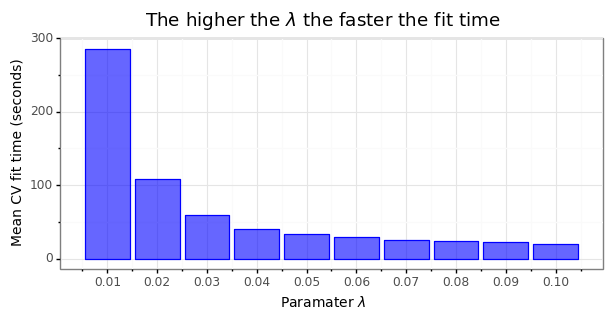

<ggplot: (8735459504511)>

In [21]:
from plotnine import *

g = (ggplot(results_df, aes(x='param_lam', y="mean_fit_time")) + 
     geom_col(color="blue", fill="blue", alpha=0.6) +
     scale_x_continuous(name="Paramater $\lambda$",
                        breaks=[x/100 for x in range(13)]) +
     scale_y_continuous(name="Mean CV fit time (seconds)") +
     theme_bw() + 
     theme(figure_size = (7, 3), axis_title=element_text(size=10)) + 
     ggtitle("The higher the $\lambda$ the faster the fit time"))

g

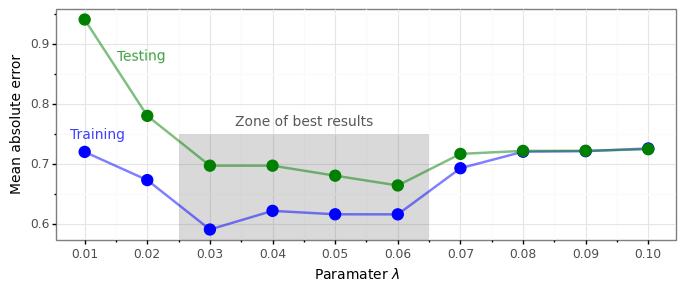

<ggplot: (8735463870675)>

In [22]:
g = (ggplot(results_df, aes(x='param_lam')) + 
     geom_rect(xmin=0.025, xmax=0.065, ymin=0.5, ymax=0.75, fill='#212121', alpha=0.015) +
     geom_point(aes(y="-mean_train_neg_mean_absolute_error"), 
                size=4, color="blue", fill="blue", alpha=1) +
     geom_line(mapping=aes(y="-mean_train_neg_mean_absolute_error"), 
               size=1, color="blue", alpha=0.5) +
     geom_point(aes(y="-mean_test_neg_mean_absolute_error"), 
                size=4, color="green", fill="green", alpha=1) +
     geom_line(mapping=aes(y="-mean_test_neg_mean_absolute_error"), 
               size=1, color="green", alpha=0.5) +
     scale_x_continuous(name="Paramater $\lambda$", breaks=[x/100 for x in range(12)]) +
     scale_y_continuous(name="Mean absolute error") +
     annotate("text", label="Testing", color="green", 
              alpha=0.75, x=0.019, y=0.88, size=10, angle=1, fontweight="normal") +
     annotate("text", label="Training", color="blue", 
              alpha=0.75, x=0.012, y=0.75, size=10, angle=0, fontweight="normal") +
      annotate("text", label="Zone of best results", color="#212121", 
          alpha=0.75, x=0.045, y=0.771, size=10, fontweight="normal") +
     theme_bw() + 
     theme(figure_size = (8, 3), axis_title=element_text(size=10)))

g

**Evaluate fitting**

Apply modSAR predictions to the entire dataset, to assess fitting accuracy

MAE: 0.62 (+- 0.63)


/mnt/code/oplrareg/models.py:172: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for r in list(self.r))


<AxesSubplot:>

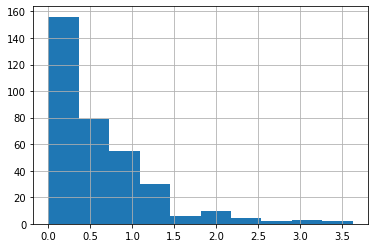

In [23]:
y_predicted = model_morgan2.predict(dataset_morgan2.X)
error = y_predicted - dataset_morgan2.y["pIC50"]

print("MAE: %.2f (+- %.2f)" % 
      (mean_absolute_error(dataset_morgan2.y, y_predicted),
       np.std(abs(error))))

pd.Series(abs(error)).hist()

### Dataset: Morgan (radius=4)

In [4]:
modsar_alg.fit(dataset_morgan4.X, dataset_morgan4.y)

Calculating fingerprints
Calculating similarity
Best Threshold = 0.20 | ACC = 0.848
Threshold: 0.2 | k: 0
Communities: Counter({'m05': 121, 'm06': 117, 'm01': 52, 'm03': 47, 'm07': 8, 'm02': 1, 'm04': 1})
Num. samples in comm m01: 52
OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 1
SELECTED FEATURES:
['Bit_0065', 'Bit_0110', 'Bit_0147', 'Bit_0187', 'Bit_0193', 'Bit_0211', 'Bit_0230', 'Bit_0236', 'Bit_0305', 'Bit_0316', 'Bit_0345', 'Bit_0350', 'Bit_0360', 'Bit_0389', 'Bit_0393', 'Bit_0406', 'Bit_0429', 'Bit_0452', 'Bit_0470', 'Bit_0478', 'Bit_0486', 'Bit_0528', 'Bit_0530', 'Bit_0542', 'Bit_0562', 'Bit_0570', 'Bit_0609', 'Bit_0621', 'Bit_0669', 'Bit_0674', 'Bit_0678', 'Bit_0704', 'Bit_0753', 'Bit_0780', 'Bit_0788', 'Bit_0790', 'Bit_0799', 'Bit_0809', 'Bit_0826', 'Bit_0874', 'Bit_0896', 'Bit_0920', 'Bit_0928', 'Bit_0961', 'Bit_0989']

None

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0065 (loop 1/45) ###########

OplraRegularised(lam=0.02, sol


OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0352 (loop 17/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0366 (loop 18/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0381 (loop 19/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0383 (loop 20/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0389 (loop 21/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0398 (loop 22/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0415 (loop 23/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0437 (loop 24/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0463 (loop 25/56) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
######


OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0644 (loop 31/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0646 (loop 32/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0649 (loop 33/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0657 (loop 34/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0666 (loop 35/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0668 (loop 36/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0680 (loop 37/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0694 (loop 38/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0696 (loop 39/60) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
######


OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0547 (loop 39/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0552 (loop 40/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0557 (loop 41/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0561 (loop 42/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0590 (loop 43/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0612 (loop 44/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0623 (loop 45/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0624 (loop 46/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
########## R = 2 f* = Bit_0645 (loop 47/62) ###########

OplraRegularised(lam=0.02, solver_name='cplex')
######

In [6]:
results_df = pd.DataFrame(model_morgan4.cv_results_)
results_df["param_lam"] = results_df["param_lam"].astype(float)

selected_cols = [col for col in results_df.columns if 'split' not in col and 'std' not in col]
#results_df.loc[:, selected_cols].sort_values("param_lam")

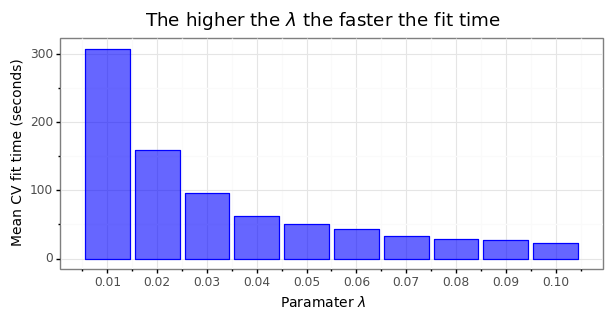

<ggplot: (-9223363273248306730)>

In [7]:
from plotnine import *

g = (ggplot(results_df, aes(x='param_lam', y="mean_fit_time")) + 
     geom_col(color="blue", fill="blue", alpha=0.6) +
     scale_x_continuous(name="Paramater $\lambda$",
                        breaks=[x/100 for x in range(13)]) +
     scale_y_continuous(name="Mean CV fit time (seconds)") +
     theme_bw() + 
     theme(figure_size = (7, 3), axis_title=element_text(size=10)) + 
     ggtitle("The higher the $\lambda$ the faster the fit time"))

g

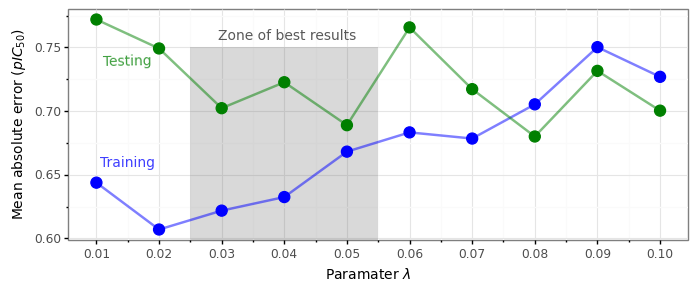

<ggplot: (8763590606449)>

In [14]:
g = (ggplot(results_df, aes(x='param_lam')) + 
     geom_rect(xmin=0.025, xmax=0.055, ymin=0.5, ymax=0.75, fill='#212121', alpha=0.015) +
     geom_point(aes(y="-mean_train_neg_mean_absolute_error"), 
                size=4, color="blue", fill="blue", alpha=1) +
     geom_line(mapping=aes(y="-mean_train_neg_mean_absolute_error"), 
               size=1, color="blue", alpha=0.5) +
     geom_point(aes(y="-mean_test_neg_mean_absolute_error"), 
                size=4, color="green", fill="green", alpha=1) +
     geom_line(mapping=aes(y="-mean_test_neg_mean_absolute_error"), 
               size=1, color="green", alpha=0.5) +
     scale_x_continuous(name="Paramater $\lambda$", breaks=[x/100 for x in range(12)]) +
     scale_y_continuous(name="Mean absolute error ($pIC_{50}$)") +
     annotate("text", label="Testing", color="green", 
              alpha=0.75, x=0.015, y=0.74, size=10, angle=1, fontweight="normal") +
     annotate("text", label="Training", color="blue", 
              alpha=0.75, x=0.015, y=0.66, size=10, angle=0, fontweight="normal") +
      annotate("text", label="Zone of best results", color="#212121", 
          alpha=0.75, x=0.0405, y=0.76, size=10, fontweight="normal") +
     theme_bw() + 
     theme(figure_size = (8, 3), axis_title=element_text(size=10)))

g

**Evaluate fitting**

Apply modSAR predictions to the entire dataset, to assess fitting accuracy.

The second model, trained on Morgan fingerprints with radius=4 seem to have produced pretty similar but slightly better results

MAE: 0.62 (+- 0.51)


/mnt/code/oplrareg/models.py:172: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for r in list(self.r))


<AxesSubplot:>

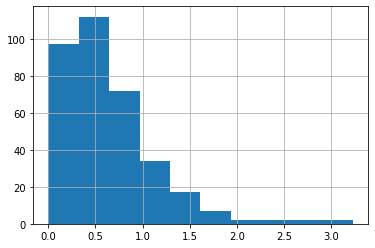

In [15]:
y_predicted = model_morgan4.predict(dataset_morgan4.X)
error = y_predicted - dataset_morgan4.y["pIC50"]
print("MAE: %.2f (+- %.2f)" % 
      (mean_absolute_error(dataset_morgan4.y, y_predicted),
       np.std(abs(error))))

pd.Series(abs(error)).hist()

# Inspection of the Graph

What did these models produce? What do they say about the data?

We can inspect the graph produced by modSAR to have a first look at the data:

In [14]:
modsar_alg = model_morgan2.best_estimator_

graph = modsar_alg.instance_graph

graph.vs['Series'] = dataset_morgan4.metadata['Series'].values

In [49]:
igraph.save(graph, "../data/model_modsar_morgan2_graph.gml")

## Visualisation

**How many clusters/modules did it find?**

In network science modules are often also called communities

In [15]:
module_sizes = pd.Series(graph.vs['community']).value_counts()
module_sizes

m05    121
m06    117
m01     52
m03     47
m07      8
m04      1
m02      1
dtype: int64

Modules m05 and m06 are the most numerous. Modules m02 and m04 are singletons: molecules in these modules are so different to the others that they do not belong to any major module.

**What does the graph look like?**

In [47]:
import igraph 

layout = graph.layout("kamada_kawai", maxiter=800, kkconst=5000)
#layout = graph.layout("graphopt")

In [17]:
pd.Series(graph.vs["Series"]).value_counts()

4       213
1        52
3        48
not4     32
2         1
TB        1
dtype: int64

In [50]:
from IPython.display import display, HTML

color_dict = {"m05": "#1B9E77",
              "m06": "#D95F02",
              "m01": "#7570B3",
              "m03": "#E7298A",
              "m07": "#66A61E",
              "m04": "#E6AB02",
              "m02": "#A6761D"}

color_dict = {"4": "#1B9E77",
              "1": "#D95F02",
              "3": "#7570B3",
              "not4": "#E7298A",
              "2": "#66A61E",
              "TB": "#E6AB02",
              "m02": "#A6761D"}





html_base = ("<span style=\"display: inline; background-color: %s;" 
            "padding: 10px; border: 1px solid gray;\">%s</span>")
final_html = "</p>Modules:</p>"
for module, color in color_dict.items():
    final_html += html_base % (color, module)
    
display(HTML(final_html, metadata=dict(isolated=True)))

In [52]:
igraph.plot(graph, "../data/model_modsar_morgan2_graph.png", 
            layout=layout, vertex_size=6, vertex_label=None, 
            vertex_color=[color_dict[comm] for comm in graph.vs["Series"]],
            edge_color="#9c9a9a", edge_curved=True, edge_width=0.2,
            background=None,
            vertex_frame_width=1.3,
            bbox=[500, 300], margin=20)

**Observations:**

- Note how modules m05 and m06 are intraconnected, molecules in these modules are very similar to each other
- There are also a lot of inter-connections between these two modules (m05 and m06)
- Module m07 seems to represent a set of of compounds similar - but not too similar - to these two main modules
- Modules m01 and m03 are very distinct. It is even possible that they could be further broken down into sub-modules

# Analysis of Modules

Ok but how can we get a sense of what these modules mean?

First, we can have a look at the Maximum Common substructure (MCS) of the molecules in each module to get a grasp of the core properties of these analogues:

In [7]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_id_mols_in_module(graph, module):
    idx_mols_in_module = np.where(np.array(graph.vs['community']) == module)[0]  
    return idx_mols_in_module

def get_mols_in_module(graph, module):
    idx_mols_in_module = get_id_mols_in_module(graph, module)
    smiles = dataset_morgan4.metadata.Canonical_Smiles.iloc[idx_mols_in_module]
    rdkit_mols = [Chem.MolFromSmiles(mol) for mol in smiles]
    return rdkit_mols

def get_mcs_pattern(graph, module):
    
    rdkit_mols = get_mols_in_module(graph, module)
    
    if len(rdkit_mols) <= 1:
        return None

    res = rdFMCS.FindMCS(rdkit_mols, 
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         completeRingsOnly=False)
    pattern = Chem.MolFromSmarts(res.smartsString)
    return pattern

def get_common_scaffold(graph, module):
    
    rdkit_mols = get_mols_in_module(graph, module)
    
    if len(rdkit_mols) <= 1:
        return None
    
    for i in range(len(rdkit_mols)):
        rdkit_mols[i] = MurckoScaffold.GetScaffoldForMol(rdkit_mols[i])
        rdkit_mols[i] = MurckoScaffold.MakeScaffoldGeneric(rdkit_mols[i])

    res = rdFMCS.FindMCS(rdkit_mols, 
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         completeRingsOnly=False)
    pattern = Chem.MolFromSmarts(res.smartsString)
    return pattern



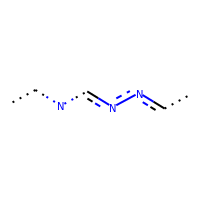
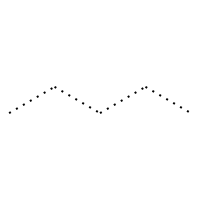
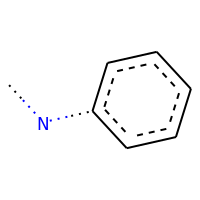
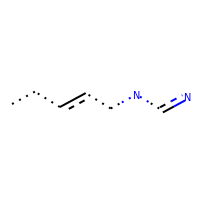
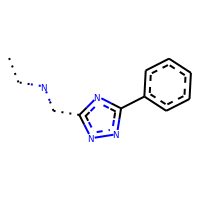

In [23]:
html_base = "Module %s %s"
html_base = ("<div style=\"display: inline-block;\">"
             "<span style=\"background-color: %s;" 
             "padding: 10px; border: 1px solid gray;\"> Module %s</span>"
             "<span style=\"display: block; padding: 10px;\">%s</span></div>")

final_html = "<p style=\"padding-bottom: 20px; font-weight: bold;\">" +\
             "Maximum Common Substructure (MCS) and common scaffold of modules</p>"
for m in module_sizes.index:
    mcs_pattern = get_mcs_pattern(graph, m)
    mcs_scaffold = get_common_scaffold(graph, m)
    if mcs_pattern is not None:
        final_html += html_base % (color_dict[m], m, mcs_pattern)
    
display(HTML(final_html))

Note that MCS of module `m07` is much more descriptive, while others are more generic. 

In [21]:
import random

def plot_molecules_in_module(graph, m, maxMols=9, fixed_idx=None):
    
    rdkit_mols = get_mols_in_module(graph, m)
    mcs_pattern = get_mcs_pattern(graph, m)
    
    if fixed_idx is None:
        fixed_idx = np.where(np.array(graph.vs['community']) == m)[0]
    else:
        rdkit_mols = [mol for i, mol in enumerate(rdkit_mols) if i in fixed_idx]
    
        
    labels = ["%s (pIC50=%.2f)" % (dataset_morgan4.y.index[label], dataset_morgan4.y.iloc[label]) 
          for label in fixed_idx]

    
    
    return Draw.MolsToGridImage(rdkit_mols,legends=labels,
                         highlightAtomLists=[rdkit_mols[i].GetSubstructMatch(mcs_pattern) 
                                             for i in range(len(rdkit_mols))] ,
                         subImgSize=(250,250), useSVG=False, maxMols=maxMols, molsPerRow=3)

## Module m05

Molecules in module 05 are indeed quite similar, these are also quite inactive (low pIC50):

/opt/conda/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 9. Change the maxMols value to display more.
  % (maxMols))


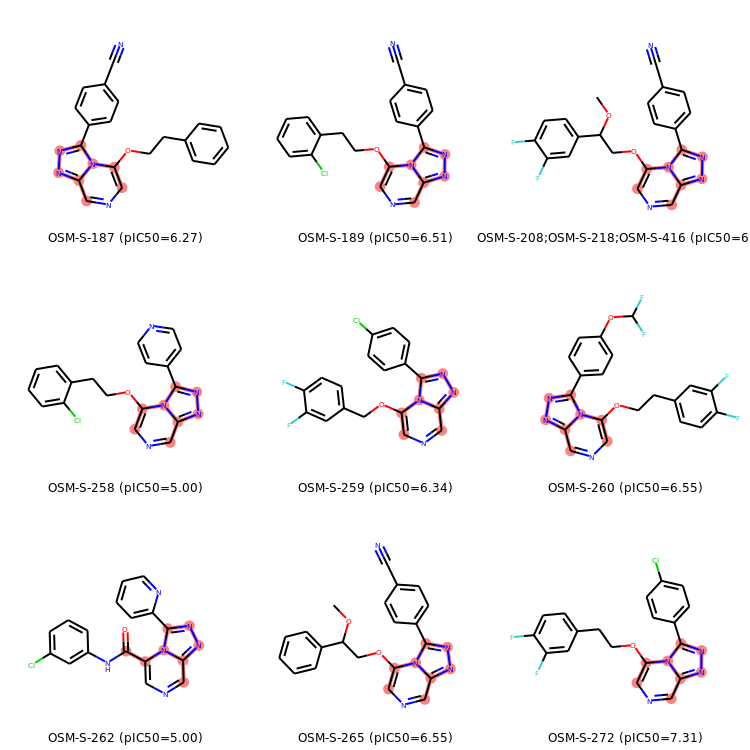

In [25]:
plot_molecules_in_module(graph, "m05")

## Module m07

Molecules in module 07 are indeed quite similar, these are also quite inactive (low pIC50):

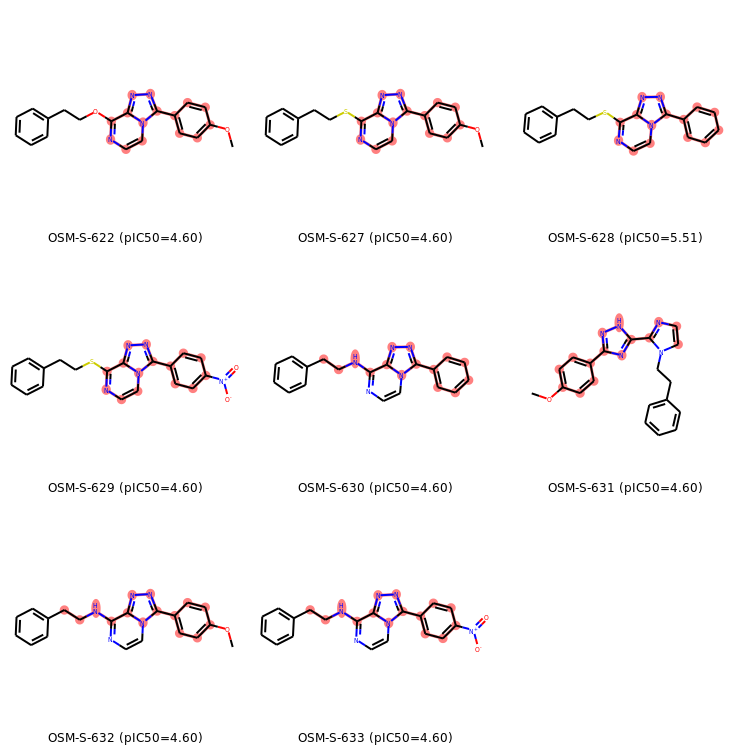

In [26]:
plot_molecules_in_module(graph, "m07")

## Module m03

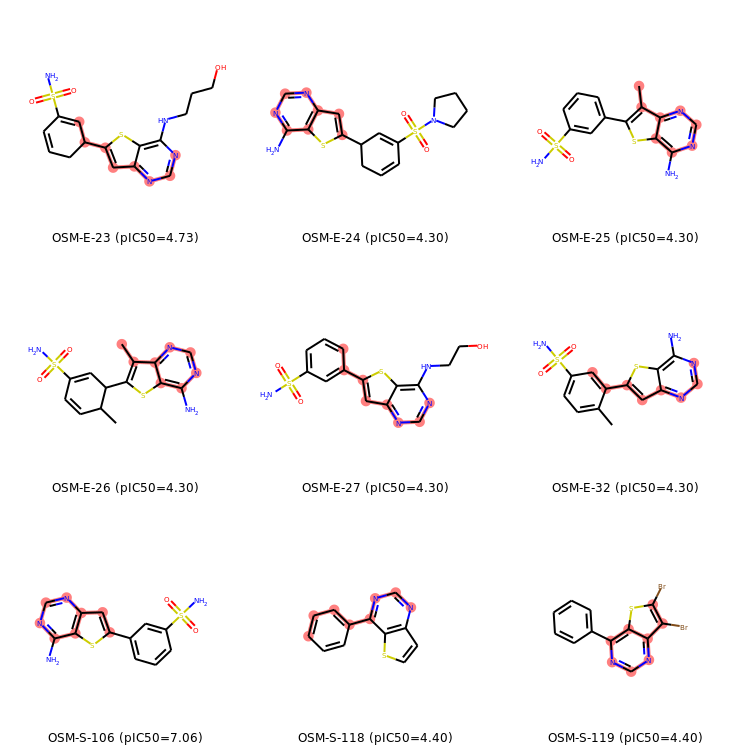

In [27]:
plot_molecules_in_module(graph, "m03")

In [5]:
def get_linear_equation(row):
    coeffs = ['%+.2f %s' % (val, coeff) for coeff, val in row.iteritems() 
              if not (math.isnan(val) or float(val) == 0) and coeff != 'B']
    equation_str = ' '.join(coeffs)
    equation_str += " %+.2f" % row['B']    
    return equation_str  

def print_module_equations(coeffs, module):
    """Helper function to print a clean representation of piecewise equations for informed module"""
    
    coeffs = coeffs.query('module == "%s"' % module)

    for idx, row in coeffs.groupby(['module', 'region']):
        equation = get_linear_equation(row.drop(columns=['module', 'region']))
        print('Equations for Module %s | Region %d\n' % (idx[0], idx[1] + 1))
        print("pIC50 = ", equation)
        print()

# Piecewise models

Every module in the graph (m01, m02, m03, etc.) is predicted by a piecewise model that we can uncover from the `<modSAR obj>.get_model_info()` function.

The function returns the linear coefficients and breakpoints used to split the data into regions.

In [6]:
coeff, breakpoints = modsar_alg.get_model_info()

The following DataFrame shows the breakpoints 

In [8]:
breakpoints

module  region breakpoints     fStar
0    m01       0        0.01  Bit_0609
1    m02       0        None      None
2    m06       0        0.01  Bit_0805
3    m03       0        0.01  Bit_0545
4    m04       0        None      None
5    m05       0        0.01  Bit_0780
6    m07       0        0.01  Bit_0518

In [11]:
coeff.sort_values(by="module")

module  region  Bit_0065  Bit_0110  ...  Bit_0842  Bit_0987  Bit_1011         B
0     m01       0 -0.013231 -0.153042  ...       NaN       NaN       NaN  5.100525
1     m01       1  0.000000  0.000000  ...       NaN       NaN       NaN  5.403438
2     m02       0       NaN       NaN  ...       NaN       NaN       NaN  4.607303
5     m03       0       NaN       NaN  ...       NaN       NaN       NaN  4.397940
6     m03       1       NaN       NaN  ...       NaN       NaN       NaN  7.055517
7     m04       0       NaN       NaN  ...       NaN       NaN       NaN  4.397940
8     m05       0       NaN       NaN  ... -0.174826 -0.135415   0.22483  4.843818
9     m05       1       NaN       NaN  ...  0.000000  0.000000   0.00000  4.886057
3     m06       0       NaN       NaN  ...       NaN       NaN       NaN  4.397940
4     m06       1       NaN       NaN  ...       NaN       NaN       NaN  5.000000
10    m07       0       NaN       NaN  ...       NaN       NaN       NaN  4.602060
11    m07       1       NaN       NaN  ...       NaN       NaN       NaN  5.511167

[12 rows x 172 columns]

**TODO: From this point on, the notebook is more on an experimental side**

# SHAP values

In [8]:
from oplrareg import OplraPyomoModel

def get_oplra_model_and_features(modsar_model, module, dataset):
    
    id_mols = get_id_mols_in_module(modsar_model.instance_graph, module)
    data = dataset.X.iloc[id_mols]
    
    oplra_model = modsar_model.models[module]
    
    fStar = oplra_model.final_model.fStar
    selected_features = oplra_model.final_model.get_selected_features(add_fstar=True)
    
    filtered_X = data.loc[:, selected_features]
    
    return oplra_model, filtered_X

In [9]:
import shap

module = "m05"

oplra_model, filtered_X = get_oplra_model_and_features(modsar_alg, module, dataset_morgan4)

# Ideal
# explainer = shap.TreeExplainer(oplra_ecfp4)

explainer = shap.KernelExplainer(oplra_model.predict, filtered_X.values)
shap_values = explainer.shap_values(filtered_X, nsamples=100)

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Using 121 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=121.0), HTML(value='')))

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
array

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
array

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
array

In [10]:
from ipywidgets import interact,fixed,IntSlider
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))


def show_bits(dataset, id_mols, idx):
    smiles = dataset.metadata.Canonical_Smiles.iloc[id_mols]
    rdkit_mols = [Chem.MolFromSmiles(mol) for mol in smiles]

    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(rdkit_mols[idx], radius=4, nBits=1024, bitInfo=bi)


    bits = list(bi.keys())
    # img2 = Draw.DrawMorganBit(m2, 999, bi)

    return interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(rdkit_mols[idx]),
             bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));

## Module 05

**Reminder: what is the fragment that describes this module m05?**

In [14]:
print_module_equations(coeff, "m05")

Equations for Module m05 | Region 1

pIC50 =  +0.07 Bit_0674 +0.46 Bit_0896 -0.10 Bit_0381 +0.03 Bit_0561 -0.42 Bit_0650 +0.27 Bit_0543 +0.05 Bit_0775 -0.07 Bit_0075 +0.06 Bit_0099 +0.25 Bit_0103 +0.04 Bit_0112 +0.02 Bit_0113 +0.18 Bit_0118 -0.34 Bit_0128 -0.11 Bit_0129 +0.10 Bit_0135 -0.15 Bit_0139 -0.02 Bit_0178 +0.24 Bit_0203 +0.13 Bit_0216 +0.24 Bit_0225 -0.80 Bit_0233 -0.02 Bit_0250 -0.25 Bit_0263 +0.06 Bit_0279 -0.28 Bit_0284 -0.22 Bit_0297 -0.01 Bit_0310 +0.01 Bit_0324 +0.04 Bit_0338 -0.17 Bit_0355 +0.04 Bit_0368 +0.15 Bit_0375 +0.30 Bit_0386 -0.24 Bit_0456 +0.06 Bit_0503 -0.07 Bit_0546 +0.20 Bit_0547 -0.35 Bit_0552 +0.06 Bit_0557 -0.41 Bit_0590 +0.29 Bit_0612 -0.11 Bit_0623 +0.09 Bit_0645 +0.04 Bit_0647 +0.03 Bit_0659 -0.26 Bit_0673 +0.18 Bit_0802 +0.32 Bit_0805 +0.18 Bit_0808 -0.17 Bit_0842 -0.14 Bit_0987 +0.22 Bit_1011 +4.84

Equations for Module m05 | Region 2

pIC50 =   +4.89



**What are the regions found for these molecules?**

Module m05 is where most OSM-S4 are and are further split into two distinct groups:

$\text{Bit_0780} = 0$ (Region 01)

$\text{Bit_0780} = 1$ (Region 02)

**What does Bit0890 represent?**

In [27]:
id_mols = get_id_mols_in_module(modsar_alg.instance_graph, "m05")

In [37]:
np.argwhere(dataset_morgan4.X.iloc[id_mols]["Bit_0780"].values == 1).flatten()

array([ 66,  67, 101, 116])

In [38]:
show_bits(dataset_morgan4, id_mols, 66)

interactive(children=(Dropdown(description='bitIdx', options=(1, 13, 20, 29, 45, 69, 74, 80, 90, 99, 103, 104, 136, 140, 142, 144, 147, 155, 198, 216, 219, 227, 231, 248, 270, 296, 310, 336, 356, 378, 399, 407, 428, 433, 484, 490, 492, 509, 511, 515, 531, 547, 548, 554, 579, 605, 632, 647, 695, 698, 699, 711, 726, 730, 741, 757, 772, 780, 788, 808, 809, 816, 819, 824, 827, 843, 849, 852, 866, 875, 877, 888, 890, 896, 904, 915, 935, 957, 999), value=1), Output()), _dom_classes=('widget-interact',))

<function __main__.renderFpBit(mol, bitIdx, bitInfo, fn)>

In [56]:
np.argwhere(dataset_morgan4.X.iloc[id_mols].index == "OSM-S-526")

array([[66]])

In [47]:
dataset_morgan4.X.iloc[id_mols[[66,67, 101, 116]],][["Bit_0780"]]

Bit_0780
OSM_ID                       
OSM-S-526                   1
OSM-S-527                   1
OSM-S-586;OSM-S-636         1
OSM-S-417                   1

**What are the equations of each region?**

In [29]:
print_module_equations(coeff, 'm05')

Equations for Module m05 | Region 1

pIC50 =  +0.07 Bit_0674 +0.46 Bit_0896 -0.10 Bit_0381 +0.03 Bit_0561 -0.42 Bit_0650 +0.27 Bit_0543 +0.05 Bit_0775 -0.07 Bit_0075 +0.06 Bit_0099 +0.25 Bit_0103 +0.04 Bit_0112 +0.02 Bit_0113 +0.18 Bit_0118 -0.34 Bit_0128 -0.11 Bit_0129 +0.10 Bit_0135 -0.15 Bit_0139 -0.02 Bit_0178 +0.24 Bit_0203 +0.13 Bit_0216 +0.24 Bit_0225 -0.80 Bit_0233 -0.02 Bit_0250 -0.25 Bit_0263 +0.06 Bit_0279 -0.28 Bit_0284 -0.22 Bit_0297 -0.01 Bit_0310 +0.01 Bit_0324 +0.04 Bit_0338 -0.17 Bit_0355 +0.04 Bit_0368 +0.15 Bit_0375 +0.30 Bit_0386 -0.24 Bit_0456 +0.06 Bit_0503 -0.07 Bit_0546 +0.20 Bit_0547 -0.35 Bit_0552 +0.06 Bit_0557 -0.41 Bit_0590 +0.29 Bit_0612 -0.11 Bit_0623 +0.09 Bit_0645 +0.04 Bit_0647 +0.03 Bit_0659 -0.26 Bit_0673 +0.18 Bit_0802 +0.32 Bit_0805 +0.18 Bit_0808 -0.17 Bit_0842 -0.14 Bit_0987 +0.22 Bit_1011 +4.84

Equations for Module m05 | Region 2

pIC50 =   +4.89



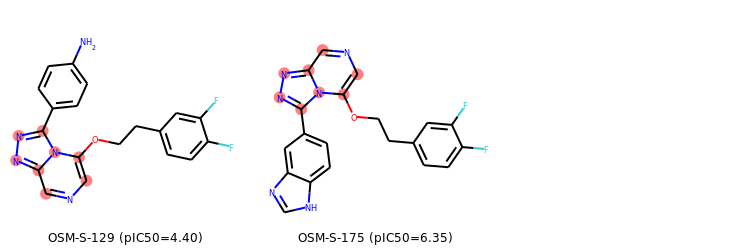

In [76]:
plot_molecules_in_module(modsar_alg.instance_graph, "m05", 6, [66,101])

## Force Plot single sample

In [69]:
filtered_X.shape

(121, 54)

In [78]:
shap.initjs()
    
idx = 66
    
shap.force_plot(explainer.expected_value, shap_values[idx,:], filtered_X.iloc[idx])

In [79]:
shap.force_plot(explainer.expected_value, shap_values, filtered_X)

## Summary Plot 

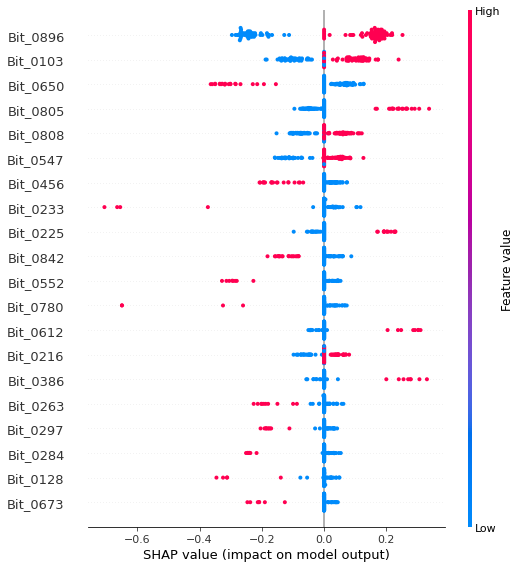

In [80]:
shap.summary_plot(shap_values, filtered_X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


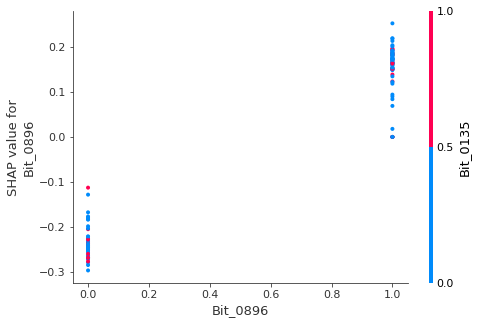

In [81]:
shap.dependence_plot("Bit_0896", shap_values, filtered_X)

### Structural Similarity

In [ ]:
idx_mols_in_m02 = np.where(np.array(graph.vs['community']) == 'm07')[0]
region01 = idx_mols_in_m02[dataset_morgan4.X.iloc[idx_mols_in_m02]['Bit_0518'] < 0.26] 
region02 = idx_mols_in_m02[(dataset_morgan4.X.iloc[idx_mols_in_m02]['Bit_0518'] > 0.26)]

smiles_m02 = dataset_morgan4.metadata.Canonical_Smiles.iloc[region01]
rdkit_mols = [Chem.MolFromSmiles(mol) for mol in smiles_m02]

res = rdFMCS.FindMCS(rdkit_mols)
pattern = Chem.MolFromSmarts(res.smartsString)
pattern

In [ ]:
AllChem.Compute2DCoords(pattern)
for m in rdkit_mols:
    AllChem.GenerateDepictionMatching2DStructure(m,pattern)
    
from rdkit.Chem import Draw

labels = ["%s [%s] (pIC50=%.2f)" % (label, "R1" if label in region01 else "R2", dataset_morgan4.y.iloc[label]) 
          for label in idx_mols_in_m02]

Draw.MolsToGridImage(rdkit_mols,legends=labels,
                     highlightAtomLists=[rdkit_mols[i].GetSubstructMatch(pattern) 
                                         for i in range(len(rdkit_mols))] ,
                     subImgSize=(250,250), useSVG=False)

In [ ]:
from ipywidgets import interact,fixed,IntSlider
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))


bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(rdkit_mols[1], radius=4, nBits=1024, bitInfo=bi)


bits = list(bi.keys())
# img2 = Draw.DrawMorganBit(m2, 999, bi)

interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(rdkit_mols[0]),
         bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));

In [ ]:
graph.vs['activity'] = osm4_dataset.y['pIC50'].values
graph.vs['C3SP2'] = osm4_dataset.X_norm['C3SP2'].values

In [ ]:
graph.write_gml('/mnt/data/OSM-S4/osm-s4-graph.gml')

### Most representative structure (region 01)

In [ ]:
degrees = np.array([graph.vs[i]['degree'] for i in region01])
most_representative = dataset_morgan4.metadata.Canonical_Smiles.iloc[region01[np.argmax(degrees)]]
Chem.MolFromSmiles(most_representative)

### Most representative structure (region 02)

In [ ]:
degrees = np.array([graph.vs[i]['degree'] for i in region02])
most_representative = dataset_morgan4.metadata.Canonical_Smiles.iloc[region02[np.argmax(degrees)]]
Chem.MolFromSmiles(most_representative)

# External (hidden) Test Set

Predict samples in test set

In [ ]:
test_set = pd.read_excel('../data/Round 2 Test Set.xlsx')
test_set.shape

In [ ]:
test_set.set_index('OSM Code', inplace=True)

## Calculate Molecular Descriptors

- Calculate descriptors
- Select only those used by model

In [ ]:
n_bits = 1024
smiles = test_set["SMILES"]

descriptors_df = pd.DataFrame(columns=['Bit_%04d' % x for x in range(n_bits)],
                              index=test_set.index, dtype=int)
for i in range(len(smiles)):
    try:
        molecule = AllChem.MolFromSmiles(smiles.iloc[i])
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 4, nBits=n_bits)
        for j in range(n_bits):
            descriptors_df.iloc[i][j] = int(fingerprint.ToBitString()[j])
    except Exception:
        print("Error parsing molecule %s" % (smiles.index[i]))
    
descriptors_df

In [ ]:
selected_idx = np.where(test_set_descriptors.iloc[0,].isnull() > 0)[0].tolist()
for i in selected_idx:
    test_set_descriptors.iloc[0, i] = test_set_descriptors.iloc[1, i]

In [ ]:
#test_set_descriptors.drop(columns=selected_idx, inplace=True)

## Apply modSAR

In [ ]:
test_set.rename(columns={"SMILES":"Canonical_Smiles"}, inplace=True)
test_set 

In [ ]:
test_set.index.name = results_ecfp4.best_estimator_.metadata.index.name

In [ ]:
results_ecfp4.best_estimator_.metadata = pd.concat([results_ecfp4.best_estimator_.metadata, test_set])

In [ ]:
test_set_X = descriptors_df.drop(index=["OSM-LO-1"])[osm4_dataset_ecfp4.X.columns]
test_set_X

In [ ]:
from collections import Counter

def get_neighbours_modules(mol_id):
    rdkit_mol = rdkit.Chem.MolFromSmiles(results_ecfp4.best_estimator_.metadata["Canonical_Smiles"].loc[mol_id])
    fp_sample = AllChem.GetMorganFingerprintAsBitVect(rdkit_mol, 4, nBits=1024)

    similarities = [rdkit.DataStructs.TanimotoSimilarity(fp_sample, fp_training)
                    for fp_training in results_ecfp4.best_estimator_.fingerprints_training]
    similarities = np.array(similarities)

    neighbours = np.argwhere(similarities >= results_ecfp4.best_estimator_.threshold).flatten()
    if len(neighbours) <= 1:
        neighbours = np.array([similarities.argmax()])

    modules_training = np.array(results_ecfp4.best_estimator_.instance_graph.vs["community"])
    neighbours_modules = Counter(modules_training[neighbours])
    return {neigh: (modules_training[neigh], similarities[neigh]) for neigh in neighbours}

In [ ]:
get_neighbours_modules("OSM-S-662")

In [ ]:
pd.Series(results_ecfp4.best_estimator_.instance_graph.vs["community"]).value_counts()

In [ ]:
results_ecfp4.best_estimator_.metadata["Canonical_Smiles"].loc["OSM-S-692"]

In [ ]:
idx = list(range(267)) + list(range(267 + 1, 381))

In [ ]:
results_ecfp4.best_estimator_.metadata = results_ecfp4.best_estimator_.metadata.iloc[idx]

In [ ]:
test_set_X = descriptors_df.drop(index=["OSM-LO-1"])[osm4_dataset_ecfp4.X.columns]

pred_IC50_modsar = results_ecfp4.predict(test_set_X)
pred_IC50_modsar = pd.DataFrame(pred_IC50_modsar)
pred_IC50_modsar.columns = ["pIC50"]
pred_IC50_modsar.index = test_set_X.index

pred_IC50_modsar['prediction (uM)'] = pred_IC50_modsar["pIC50"].apply(lambda x: math.pow(10, -x,)/(1e-6))
pred_IC50_modsar["prediction (uM)"].values

## Apply RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(osm4_dataset.X, osm4_dataset.y)

In [ ]:
pred_IC50 = pd.Series(rf.predict(test_set_descriptors[osm4_dataset.X.columns]), name='pIC50')
pred_IC50.index = test_set['SMILES'].index

In [ ]:
result = pd.concat([test_set['SMILES'], pred_IC50], axis=1)
result['prediction modSAR-Random Forest (uM)'] = result.apply(lambda x: math.pow(10, -x['pIC50'],)/(1e-6), axis=1)

In [ ]:
result

In [ ]:
from rdkit.Chem import PandasTools

In [ ]:
experimental_vals = [2, 2.63, 0.159, 0.89, 0.19, 0.094, 0.304, 0.124, 0.722, 9.538, 9.69, 25, 9.94, 0.605, 1.06, 4.57, 4.23, 25, 16.17, 7.81, 25, 17.02, 0.367, 1.71, 14.25, 25, 25, 25, 25, 10.13, 1.25, 9.94, 14.55, 25]
result["Experimental (uM)"] = experimental_vals

In [ ]:
result

In [ ]:
sim = result.drop(columns=["pIC50"]).copy()

PandasTools.AddMoleculeColumnToFrame(sim, "SMILES", "Molecule")
# print(sim.to_latex())

In [ ]:
sim

In [ ]:
result.to_csv('/mnt/data/OSM-S4/submission-jonathan-cardoso-silva-rf.csv')

## RF on the modules

Instead of OPLRAreg, use RF on the modules

In [ ]:
from collections import Counter

def classify_sample(alg, sample_smiles, cdk_utils=None):
    """"""

    if cdk_utils is None:
        cdk_utils = CDKUtils()

    fp_sample = cdk_utils.calculate_fingerprint(sample_smiles)

    if alg.fingerprints_training is None:
        print("Recalculating fingerprints for samples in the graph.")
        alg.fingerprints_training = [cdk_utils.calculate_fingerprint(smiles)
                                      for smiles in alg.instance_graph.vs['SMILES']]

    similarities = [cdk_utils.cdk.similarity.Tanimoto.calculate(fp_sample, fp_training)
                    for fp_training in alg.fingerprints_training]
    similarities = np.array(similarities)

    neighbours = np.argwhere(similarities >= alg.threshold).flatten()
    if len(neighbours) <= 1:
        neighbours = np.array([similarities.argmax()])

    modules_training = np.array(alg.instance_graph.vs["community"])
    neighbours_modules = Counter(modules_training[neighbours])
    # Maximum number of links to a module
    max_links = neighbours_modules.most_common(1)[0][1]
    max_modules = [k for k, v in neighbours_modules.items() if v == max_links]
    
    if len(max_modules) == 1:
        comm = max_modules[0]
        dist_to_modules = {comm: np.average(similarities[np.argwhere(modules_training == comm).flatten()])}
    else:
        dist_to_modules = {comm: np.average(similarities[np.argwhere(modules_training == comm).flatten()])
                           for comm in max_modules}
    closest_module = max(dist_to_modules, key=lambda x: dist_to_modules[x])
    return closest_module

In [ ]:
pd.Series([classify_sample(alg, mol) for mol in test_set['SMILES']]).value_counts()

### RF on module m02

In [ ]:
from sklearn.ensemble import RandomForestRegressor

idx_mols_in_m02 = np.where(np.array(alg.instance_graph.vs['community']) == 'm02')[0]

rf_m02 = RandomForestRegressor(n_estimators=100)
rf_m02.fit(osm4_dataset.X.iloc[idx_mols_in_m02], osm4_dataset.y.iloc[idx_mols_in_m02])

### RF on module m04

In [ ]:
idx_mols_in_m04 = np.where(np.array(alg.instance_graph.vs['community']) == 'm04')[0]

rf_m04 = RandomForestRegressor(n_estimators=100)
rf_m04.fit(osm4_dataset.X.iloc[idx_mols_in_m04], osm4_dataset.y.iloc[idx_mols_in_m04])

In [ ]:
def apply_custom_rf(df):
    
    # Check which module the module belongs to
    
    module = classify_sample(alg, df['SMILES'])
    row = df.drop(['SMILES']).to_frame().transpose()
    
    if module == 'm02':
        result = rf_m02.predict(row)
    elif module == 'm04':
        result = rf_m04.predict(row)

    return result[0]

predIC50 = pd.concat([test_set_descriptors[osm4_dataset.X.columns], test_set['SMILES']], axis=1)\
                .apply(apply_custom_rf, axis=1)
predIC50 = pd.DataFrame(predIC50, columns=['pIC50'])

In [ ]:
result = pd.concat([test_set['SMILES'], predIC50], axis=1)
result['prediction (uM)'] = result.apply(lambda x: math.pow(10, -x['pIC50'],)/(1e-6), axis=1)
result['prediction (uM)']

In [ ]:
result.to_csv('/mnt/data/OSM-S4/submission-jonathan-cardoso-silva-modular-rf.csv')